# K-means Clustering: Mall customer dataset


## Lectura de datos
Como paso preliminar examinaremos el dataset que estaremos utilizando, precisamente será el Mall Customer dataset

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

file_name = "Mall_Customers.csv"
data = pd.read_csv(file_name)
data.head()

,CustomerID,Genre,Age,Annual_Income_(k$),Spending_Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   CustomerID          200 non-null    int64 
 1   Genre               200 non-null    object
 2   Age                 200 non-null    int64 
 3   Annual_Income_(k$)  200 non-null    int64 
 4   Spending_Score      200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [3]:
data.describe()

,CustomerID,Age,Annual_Income_(k$),Spending_Score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [4]:
data.corr()

,CustomerID,Age,Annual_Income_(k$),Spending_Score
CustomerID,1.000000,-0.026763,0.977548,0.013835
Age,-0.026763,1.000000,-0.012398,-0.327227
Annual_Income_(k$),0.977548,-0.012398,1.000000,0.009903
Spending_Score,0.013835,-0.327227,0.009903,1.000000


## Planteamiento del problema
En este caso se realizarán 3 análisis complementarios:
- Annual Income vs Spending Score
- Age vs Spending Score
- Annuual Inconme vs Age vs Spending Score

En todos se implementarán los algoritmos de clasificación no supervisada de manera manual, así como la implementación de la metodología del *codo* para hallar el número óptimo de agrupamientos para el problema.

Visualizaremos los datos que queremos clasificar mediante el algoritmo de *K-means*

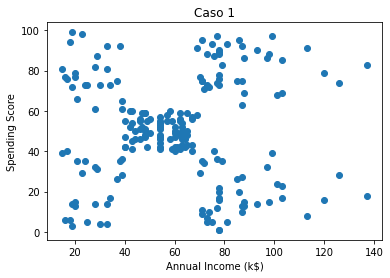

In [5]:
plt.scatter(data[['Annual_Income_(k$)']], data[['Spending_Score']])
plt.title('Caso 1')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score')
plt.show()

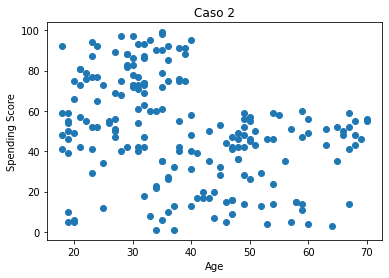

In [6]:
plt.scatter(data[['Age']], data[['Spending_Score']])
plt.title('Caso 2')
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.show()

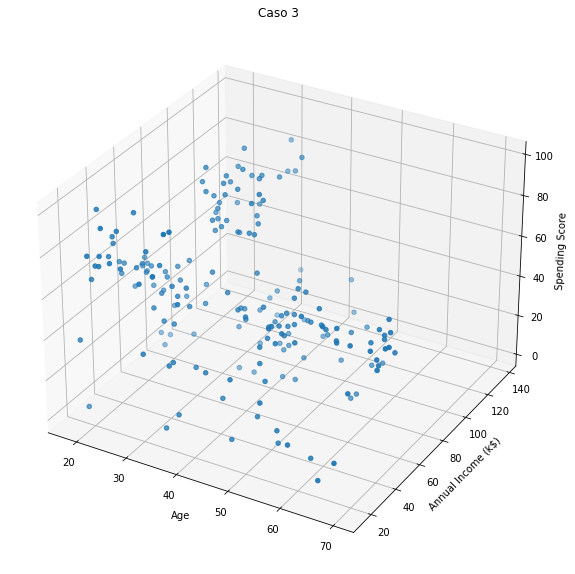

In [7]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[['Age']], data[['Annual_Income_(k$)']], data[['Spending_Score']])
plt.title('Caso 3')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score')
plt.show()

## Parte 1: Programación Manual

### Función K-means

In [8]:
def k_means_fn(qty, m, n, K, X, centroids, elbow=False):
# qty = Número de iteraciones
# m = Cantidad de datos 
# n = Número de características
# K = Número de agrupamientos
# X = Vector de datos de tamaño (mxn)
# centroids = Vector en el que se guardarán los centroides calculados, es necesario brindarle unos 
#             valores aleatorios al prinicipio

# Los valores que retorna son:
# y = un arreglo de "K" arreglos con los puntos ya agrupados, cuyos índices van de 1 a K
# centroids = El vector de centroides con los resultados finales de los cluesters

    
    for i in range(qty):
        euclidian = np.array([]).reshape(m, 0) #Estructura para guardar la distancia euclidiana
        
        for k in range(K): 
            #Calculamos la distancia euclidiana entre los puntos y los centroides
            euclidian = np.c_[euclidian, np.sum((X - centroids[:, k])**2, axis=1)]
        
        cluster = np.argmin(euclidian, axis=1) + 1
        
        #Calculamos la media de los diferentes agrupamientos (clusters)
        y = {}
        for k in range(K):
            y[k+1] = np.array([]).reshape(n, 0)
        
        #Le asignamos los clusters a cada punto 
        for i in range(m):
            y[cluster[i]] = np.c_[y[cluster[i]], X[i]]
        
        for k in range(K):
            y[k+1] = y[k+1].T
        
        for k in range(K):
            centroids[:,k]=np.mean(y[k+1],axis=0)
    
    if elbow is False:
        
        if n == 2:
            #Graficando los puntos agrupados
            for k in range(K):
                plt.scatter(y[k+1][:,0], y[k+1][:,1])

            #Graficando los centroides
            plt.scatter(centroids[0,:], centroids[1,:], s=200,c='yellow')

        if n == 3:
            #Configuraciones previas para la graficación
            fig = plt.figure(figsize=(20,10))
            ax = fig.add_subplot(111, projection='3d')

            #Graficando los puntos agrupados
            for k in range(K):
                ax.scatter(y[k+1][:,0], y[k+1][:,1], y[k+1][:,2])

            #Graficando los centroides
            ax.scatter(centroids[0,:], centroids[1,:], centroids[2,:], s=300,c='yellow')
            
            return y, centroids, ax

    return y, centroids

### Función para hallar el mejor valor de K (Elbow method)
Este método se basa en el hecho de que el mejor valor de K, es aquel que hace que la suma del cuadrado de los errores de cada punto con su correspondiente clustersea lo mínimo posible

In [10]:
def elbow_method(X, K_min=1, K_max=10):
    m = np.shape(X)[0] # Número de datos
    n = np.shape(X)[1] # Número de Características
    
    cost = []
    
    for k in range (K_min, K_max+1):
        
        #Centroides aleatorios
        c = np.array([]).reshape(n, 0) 
        for i in range(k):
            c =np.c_[c, X[random.randint(0, m - 1)]]
        
        y, c = k_means_fn(50, m, n, k, X, c, True)
        
        aux = 0
        for i in range (k):
            if n == 2:
                aux += np.sum(((y[i+1][:,0] - c[0, i])**2 + (y[i+1][:,1] - c[1, i])**2))
            else:
                aux += np.sum(((y[i+1][:,0] - c[0, i])**2 + (y[i+1][:,1] - c[1, i])**2 + (y[i+1][:,2] - c[2, i])**2))
        
        #print(f'{k} : {aux}')
        
        cost.append(aux)
    
    return cost

### Caso 1: Annual Income vs Spending Score

In [11]:
#Hacemos un preprocesamiento de los datos que se compararán
X1 = np.array(data[['Annual_Income_(k$)', 'Spending_Score']]) # Datos
m1 = np.shape(X1)[0] # Número de datos
n1 = np.shape(X1)[1] # Número de Características
K1 = 4 #Agrupamientos propuestos
it1 = 50 #Número de iteraciones

#Creamos la estructura para guardar los centroides e inicializamos aleatoriamente
c1 = np.array([]).reshape(n1, 0) 

for k in range(K1):
    c1 =np.c_[c1, X1[random.randint(0, m1 - 1)]]

print(f'Los centroides aleatorios son: \n{c1}')

Los centroides aleatorios son: 
[[ 61.  78.  49. 137.  72.  39.]
 [ 49.  78.  55.  18.  71.  36.]]


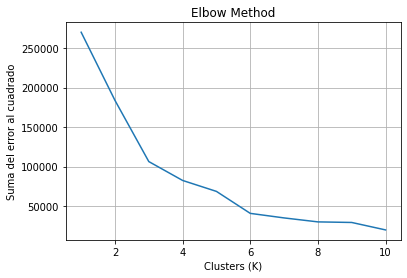

In [20]:
elbow1 = elbow_method(X1)

t = range(1,11)
plt.plot(t, elbow1)
plt.grid(True)
plt.title('Elbow Method')
plt.xlabel('Clusters (K)')
plt.ylabel('Suma del error al cuadrado')
plt.show()

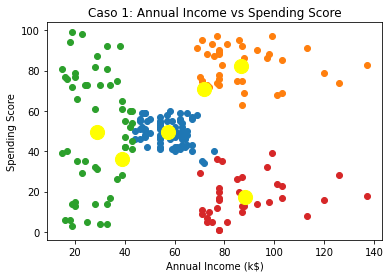

In [13]:
Y1, c1 = k_means_fn(it1, m1, n1, K1, X1, c1)

#Configuramos los parámetros de la gráfica
plt.title('Caso 1: Annual Income vs Spending Score')
plt.ylabel('Spending Score')
plt.xlabel('Annual Income (k$)')
plt.show()

### Caso 2: Age vs Spending Score

In [15]:
#Hacemos un preprocesamiento de los datos que se compararán
X2 = np.array(data[['Age', 'Spending_Score']]) # Datos
m2 = np.shape(X2)[0] # Número de datos
n2 = np.shape(X2)[1] # Número de Características
K2 = 4 #Agrupamientos propuestos
it2 = 50 #Número de iteraciones

#Creamos la estructura para guardar los centroides e inicializamos aleatoriamente
c2 = np.array([]).reshape(n2, 0) 

for k in range(K2):
    c2 =np.c_[c2, X2[random.randint(0, m2 - 1)]]

print(f'Los centroides aleatorios son: \n{c2}')

Los centroides aleatorios son: 
[[37. 20. 32. 43.]
 [13. 66. 74. 17.]]


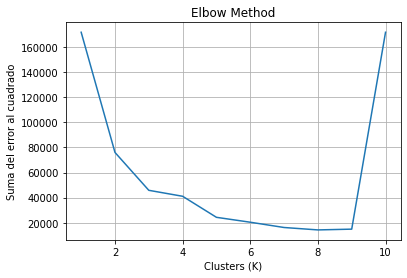

In [17]:
elbow2 = elbow_method(X2)

t = range(1,11)
plt.plot(t, elbow2)
plt.grid(True)
plt.title('Elbow Method')
plt.xlabel('Clusters (K)')
plt.ylabel('Suma del error al cuadrado')
plt.show()

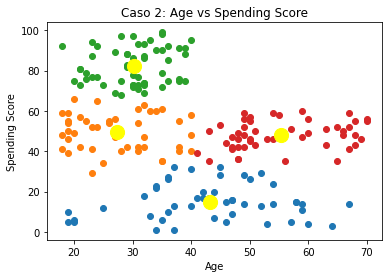

In [21]:
Y2, c2 = k_means_fn(it2, m2, n2, K2, X2, c2)

#Configuramos los parámetros de la gráfica
plt.title('Caso 2: Age vs Spending Score')
plt.ylabel('Spending Score')
plt.xlabel('Age')
plt.show()

### Caso 3: Annuual Inconme vs Age vs Spending Score

In [22]:
#Hacemos un preprocesamiento de los datos que se compararán
X3 = np.array(data[['Annual_Income_(k$)', 'Age', 'Spending_Score']]) # Datos
m3 = np.shape(X3)[0] # Número de datos
n3 = np.shape(X3)[1] # Número de Características
K3 = 6 #Agrupamientos propuestos
it3 = 50 #Número de iteraciones

#Creamos la estructura para guardar los centroides e inicializamos aleatoriamente
c3 = np.array([]).reshape(n3, 0) 

for k in range(K3):
    c3 =np.c_[c3, X3[random.randint(0, m3 - 1)]]

print(f'Los centroides aleatorios son: \n{c3}')

Los centroides aleatorios son: 
[[77. 54. 33. 29. 63. 81.]
 [25. 40. 21. 23. 65. 19.]
 [12. 48. 81. 87. 52.  5.]]


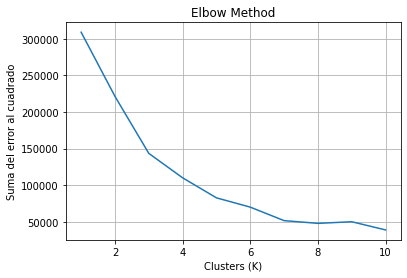

In [24]:
elbow3 = elbow_method(X3)
t = range(1,11)
plt.plot(t, elbow3)
plt.grid(True)
plt.title('Elbow Method')
plt.xlabel('Clusters (K)')
plt.ylabel('Suma del error al cuadrado')
plt.show()

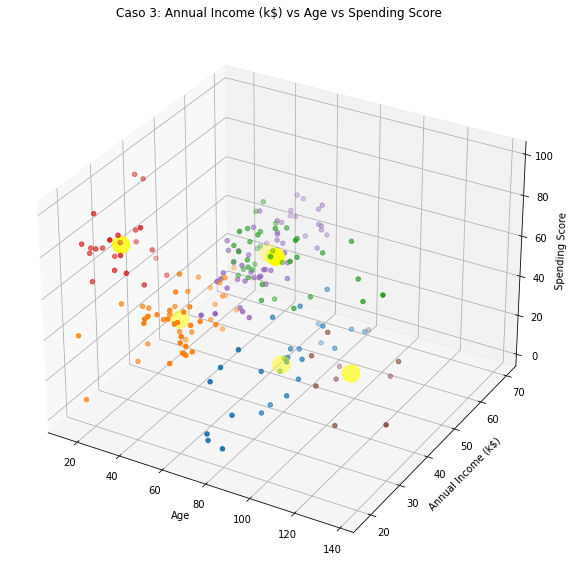

In [25]:
Y3, c3, ax = k_means_fn(it3, m3, n3, K3, X3, c3)


#Configuramos los parámetros de la gráfica
plt.title('Caso 3: Annual Income (k$) vs Age vs Spending Score')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score')
plt.show()

## Parte 2: Usando librerías

In [26]:
def elbow_method_lib(X, K_min=1, K_max=10):
    #X = Datos de entrenamiento
    cost = []
    for i in range(K_min, K_max):
        k_means = KMeans(n_clusters=i, init='k-means++')
        k_means.fit(X)
        cost.append(k_means.inertia_)
    
    return cost
    

### Caso 1: Annual Income vs Spending Score

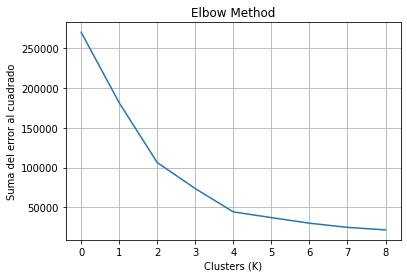

In [28]:
elbow1_lib = elbow_method_lib(X1)

plt.plot(elbow1_lib)
plt.grid(True)
plt.title('Elbow Method')
plt.xlabel('Clusters (K)')
plt.ylabel('Suma del error al cuadrado')
plt.show()

In [50]:
K1_lib = 5
k_means = KMeans(n_clusters=K1_lib, init='k-means++')
predict1 = k_means.fit_predict(X1) #Clases a las que pertenece
c1_lib = k_means.cluster_centers_ #Centroides


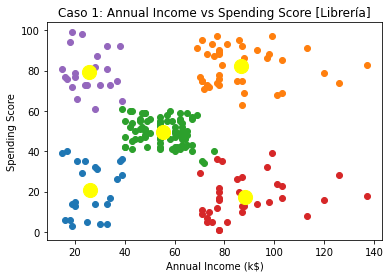

In [86]:
complete_list_1 = np.c_[X1, predict1]

for i in range(K1_lib):
    dummy = []
    
    for j in range(np.shape(complete_list_1)[0]):
        if complete_list_1[j, 2] == i:
            dummy.append(list(complete_list_1[j]))
    
    dummy_arr = np.array(dummy) #Convertimos en un array
    dummy_del = np.delete(dummy_arr, 2, 1) #Eliminamos lo que no nos sirve
    
    plt.scatter(dummy_del[:, 0], dummy_del[:, 1])

    


#Graficando los centroides
plt.scatter(c1_lib[:, 0], c1_lib[:, 1], s=200,c='yellow')

plt.title('Caso 1: Annual Income vs Spending Score [Librería]')
plt.ylabel('Spending Score')
plt.xlabel('Annual Income (k$)')
plt.show()

### Caso 2: Age vs Spending Score

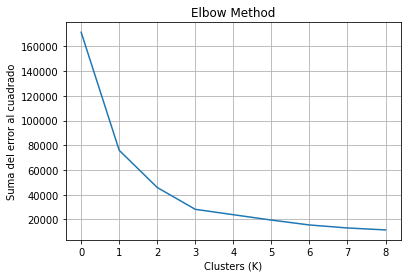

In [87]:
elbow2_lib = elbow_method_lib(X2)

plt.plot(elbow2_lib)
plt.grid(True)
plt.title('Elbow Method')
plt.xlabel('Clusters (K)')
plt.ylabel('Suma del error al cuadrado')
plt.show()

In [88]:
K2_lib = 3
k_means = KMeans(n_clusters=K2_lib, init='k-means++')
predict2 = k_means.fit_predict(X2) #Clases a las que pertenece
c2_lib = k_means.cluster_centers_ #Centroides

Text(0.5, 0, 'Age')

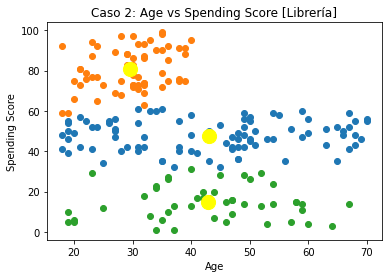

In [89]:
complete_list_2 = np.c_[X2, predict2]

for i in range(K2_lib):
    dummy = []
    
    for j in range(np.shape(complete_list_2)[0]):
        if complete_list_2[j, 2] == i:
            dummy.append(list(complete_list_2[j]))
    
    dummy_arr = np.array(dummy) #Convertimos en un array
    dummy_del = np.delete(dummy_arr, 2, 1) #Eliminamos lo que no nos sirve
    
    plt.scatter(dummy_del[:, 0], dummy_del[:, 1])

    


#Graficando los centroides
plt.scatter(c2_lib[:, 0], c2_lib[:, 1], s=200,c='yellow')

plt.title('Caso 2: Age vs Spending Score [Librería]')
plt.ylabel('Spending Score')
plt.xlabel('Age')

### Caso 3: Annuual Inconme vs Age vs Spending Score

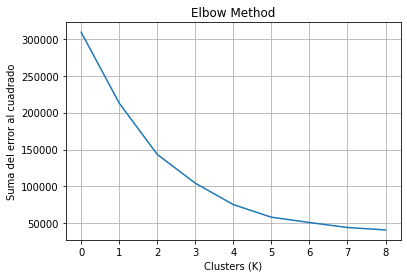

In [90]:
elbow3_lib = elbow_method_lib(X3)

plt.plot(elbow3_lib)
plt.grid(True)
plt.title('Elbow Method')
plt.xlabel('Clusters (K)')
plt.ylabel('Suma del error al cuadrado')
plt.show()

In [91]:
K3_lib = 5
k_means = KMeans(n_clusters=K3_lib, init='k-means++')
predict3 = k_means.fit_predict(X3) #Clases a las que pertenece
c3_lib = k_means.cluster_centers_ #Centroides

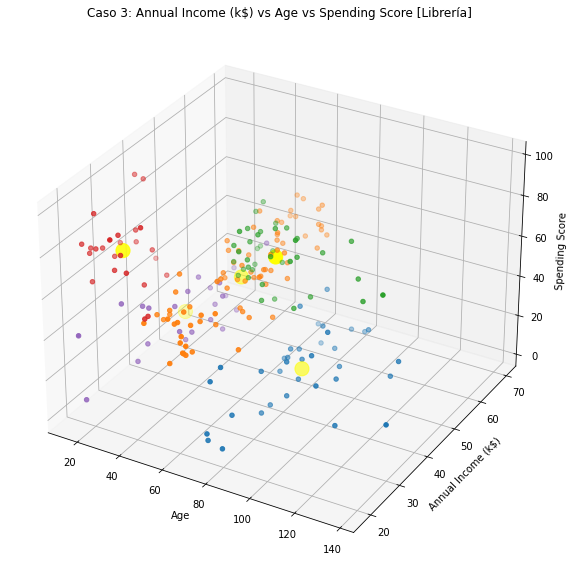

In [100]:
complete_list_3 = np.c_[X3, predict3]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

for i in range(K3_lib):
    dummy = []
    
    for j in range(np.shape(complete_list_3)[0]):
        if complete_list_3[j, 3] == i:
            dummy.append(list(complete_list_3[j]))
    
    dummy_arr = np.array(dummy) #Convertimos en un array
    dummy_del = np.delete(dummy_arr, 3, 1) #Eliminamos lo que no nos sirve
    
    ax.scatter(dummy_del[:, 0], dummy_del[:, 1], dummy_del[:, 2])

    


#Graficando los centroides
ax.scatter(c3_lib[:, 0], c3_lib[:, 1], c3_lib[:, 2], s=200,c='yellow')

plt.title('Caso 3: Annual Income (k$) vs Age vs Spending Score [Librería]')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score')
plt.show()

# Referencias
[1] https://www.machinelearningplus.com/predictive-modeling/k-means-clustering/


[2] https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html


[3] https://www.kaggle.com/shrutimechlearn/step-by-step-kmeans-explained-in-detail/notebook


[4] https://www.analyticsvidhya.com/blog/2021/05/k-means-clustering-with-mall-customer-segmentation-data-full-detailed-code-and-explanation/


[5] https://aihubprojects.com/k-means-clustering-from-scratch-python/